In [170]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import cross_val_score

In [2]:
raw_data = pd.read_csv('prostate_dataset.txt', delimiter='\t')

In [82]:
raw_data

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [4]:
raw_data.shape

(97, 11)

In [146]:
raw_data.isnull().sum()

col        0
lcavol     0
lweight    0
age        0
lbph       0
svi        0
lcp        0
gleason    0
pgg45      0
lpsa       0
train      0
dtype: int64

In [145]:
raw_data.iloc[:,1:-1].describe().round(2)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,1.35,3.63,63.87,0.10,0.22,-0.18,6.75,24.38,2.48
std,1.18,0.43,7.45,1.45,0.41,1.40,0.72,28.20,1.15
min,-1.35,2.37,41.00,-1.39,0.00,-1.39,6.00,0.00,-0.43
25%,0.51,3.38,60.00,-1.39,0.00,-1.39,6.00,0.00,1.73
50%,1.45,3.62,65.00,0.30,0.00,-0.80,7.00,15.00,2.59
75%,2.13,3.88,68.00,1.56,0.00,1.18,7.00,40.00,3.06
max,3.82,4.78,79.00,2.33,1.00,2.90,9.00,100.00,5.58


In [31]:
X = raw_data.iloc[:,1:-2]
y = raw_data.iloc[:,9]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [83]:
#X_train = raw_data.iloc[:,1:-2][raw_data['train']=='T'] #not scaled
X_train = X_scaled[raw_data['train']=='T']
y_train = raw_data.iloc[:,9][raw_data['train']=='T']
#X_test = raw_data.iloc[:,1:-2][raw_data['train']=='F'] #not scaled
X_test = X_scaled[raw_data['train']=='F']
y_test = raw_data.iloc[:,9][raw_data['train']=='F']

In [84]:
X_train.shape
X_test.shape

(30, 8)

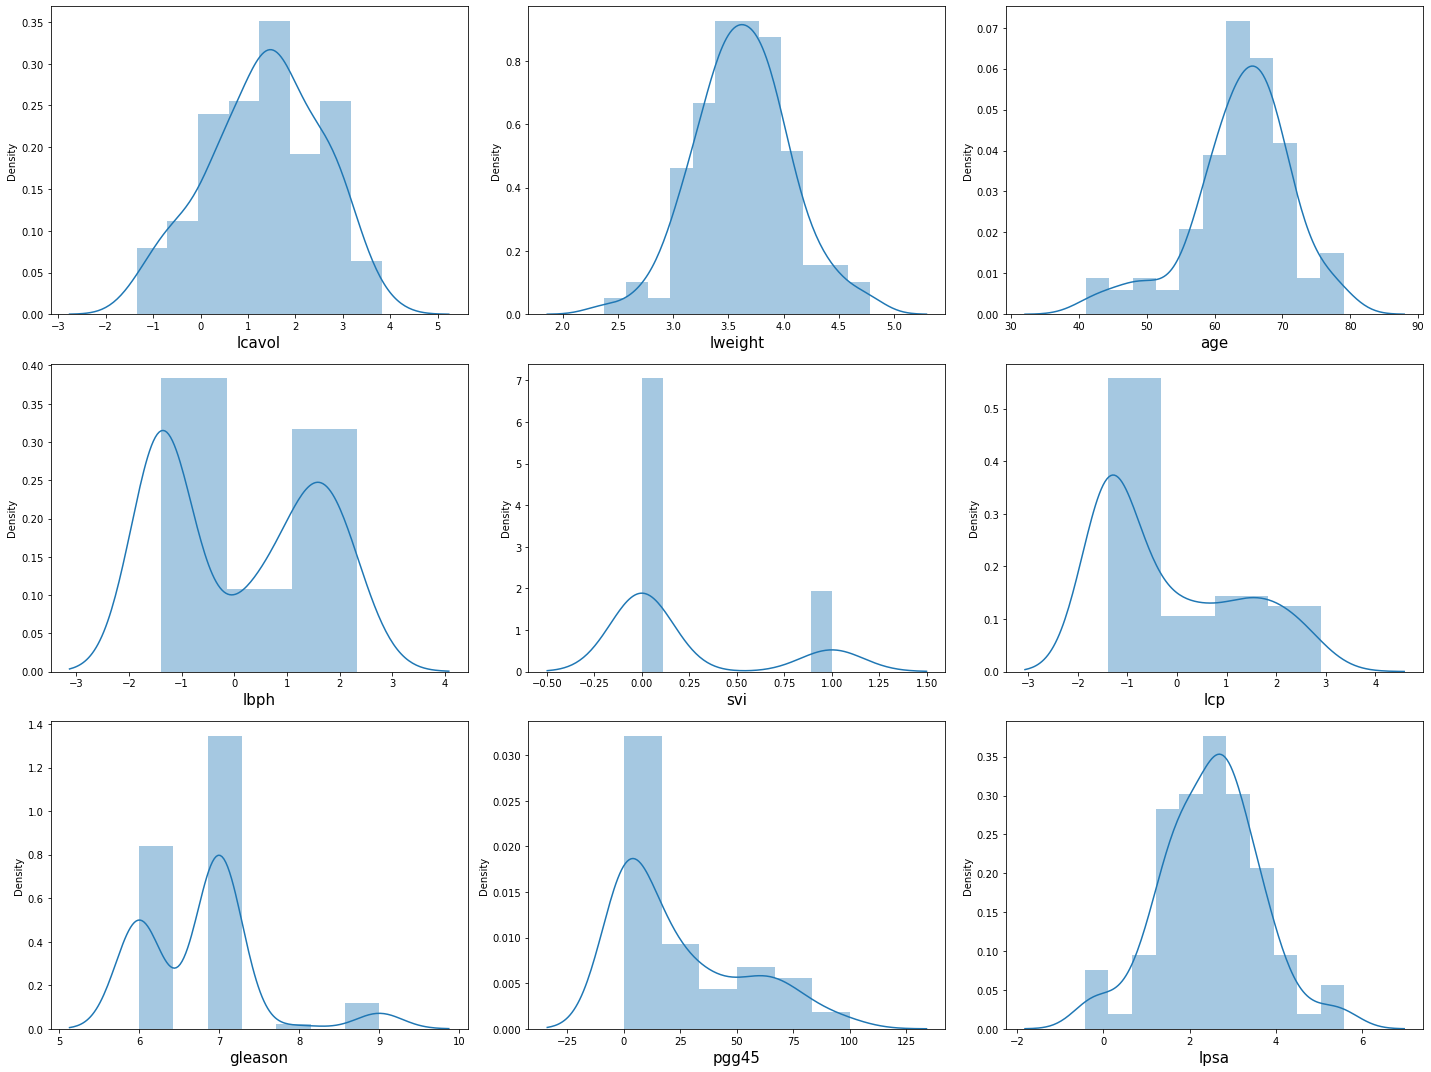

In [137]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in raw_data.iloc[:,1:-1]:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(raw_data.iloc[:,1:-1][column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

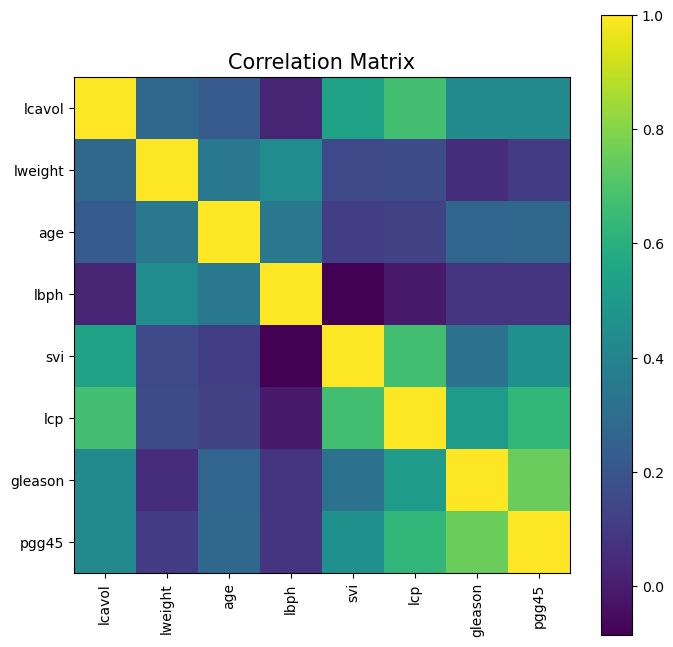

In [133]:
# Correlation matrix
def correlation_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(8,8), dpi=100)
    corr_mat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corr_mat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
correlation_matrix(X_scaled)

#from the plot below we can see that
#-->there is some correlation among regressors. E.g. gleason and pgg45 are correlated, indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score

# Linear regression baseline

In [85]:
# Linear regression model
lr = linear_model.LinearRegression()
# learn the model on the train set
lr.fit(X_train,y_train)
# baseline error
y_pred = lr.predict(X_test)
baseline_error = np.mean((y_pred - y_test) ** 2)
print("Linear regression error: %0.4f" % baseline_error)

Linear regression error: 0.5213


# Ridge regression

To avoid overfitting, ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [96]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas)

coef_ridge = []
err_ridge = []
baseline = []
for a in alphas:
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    coef_ridge.append(ridge.coef_)
    y_pred = ridge.predict(X_test)
    ridge_error = np.mean((y_pred - y_test) ** 2)
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

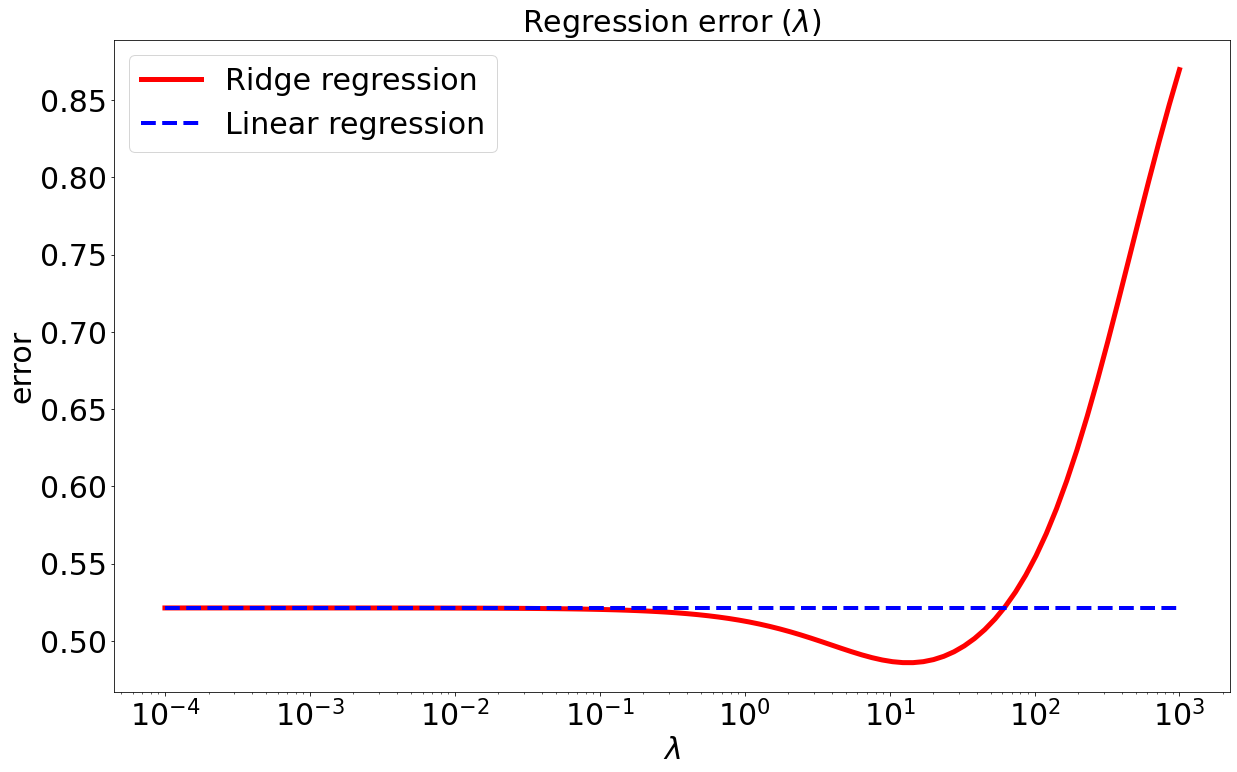

In [97]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [98]:
min(err_ridge)

0.4858675627413776

In [180]:
alphas[np.argmin(err_ridge)]

14.508287784959402

In [179]:
ridge_cv = RidgeCV(alphas = alphas, cv = 10)
ridge_cv.fit(X_train, y_train)
alpha = ridge_cv.alpha_
alpha#is different from the minimum found above (?)##############
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
pred_err_ridge = np.mean((ridge.predict(X_test) - y_test) ** 2)
print(ridge)
print(pred_err_ridge)

Ridge(alpha=45.34878508128582)
0.5072513638170324


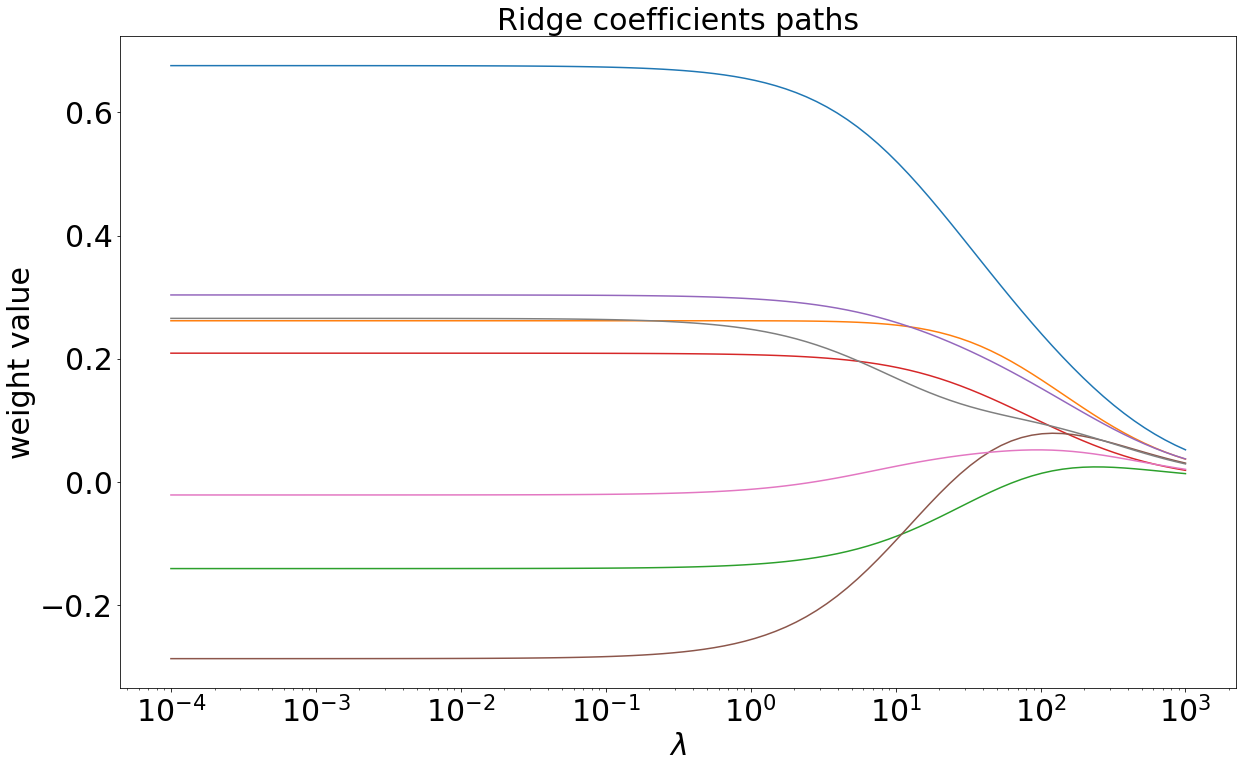

In [99]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

# Lasso regression

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero. The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [103]:
coef_lasso = []
err_lasso = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = np.mean((y_pred - y_test) ** 2)
    err_lasso.append(lasso_error)

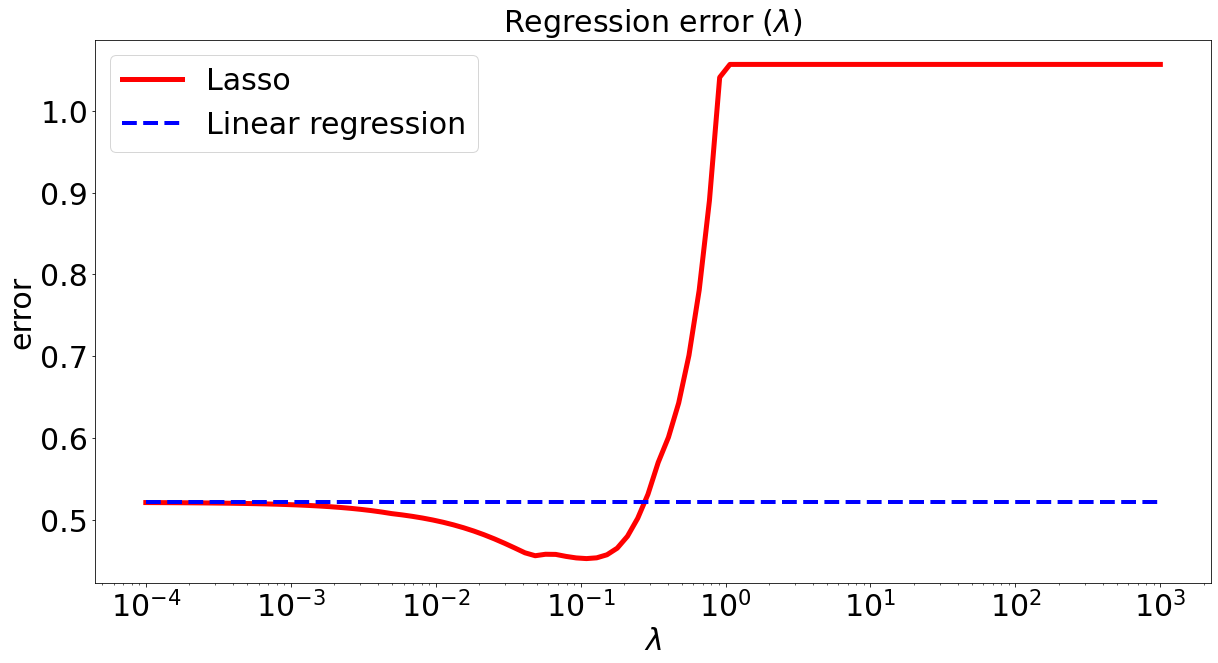

In [104]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [149]:
min(err_lasso)

0.4524744740963335

In [155]:
alphas[np.argmin(err_lasso)]

0.10974987654930557

In [177]:
lasso_cv = LassoCV(alphas = alphas, cv = 10, max_iter = 10000)
lasso_cv.fit(X_train, y_train)
alpha = lasso_cv.alpha_
alpha#is different from the minimum found above (?)##############
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)
pred_err_lasso = np.mean((lasso.predict(X_test) - y_test) ** 2)
print(lasso)
print(pred_err_lasso)

Lasso(alpha=0.003593813663804626)
0.5111564471864999


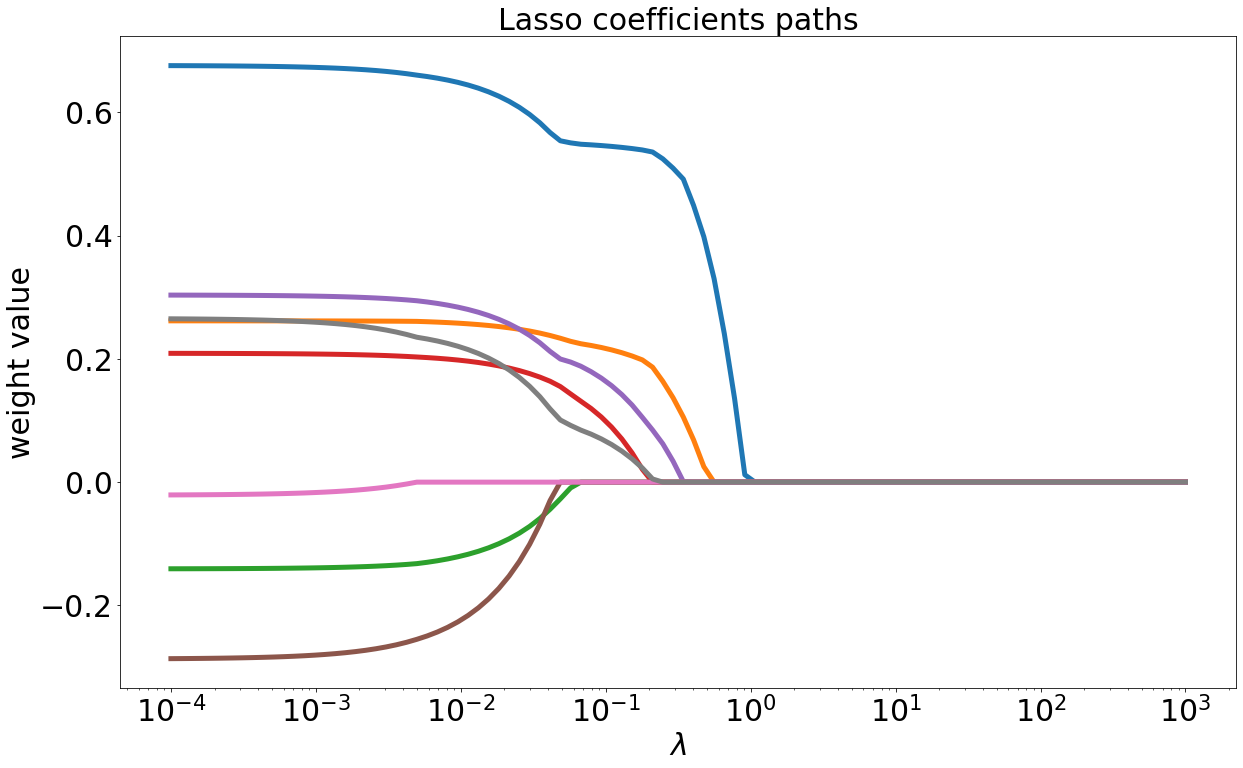

In [105]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

# Elastic Net regression

Elastic Net overcomes the issue of losing information. It has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression. Thus the Elastic net model is less sparse than the Lasso, keeping more information.

In [110]:
coef_eln = []
err_eln = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = np.mean((y_pred - y_test) ** 2)
    err_eln.append(elasticnet_error)

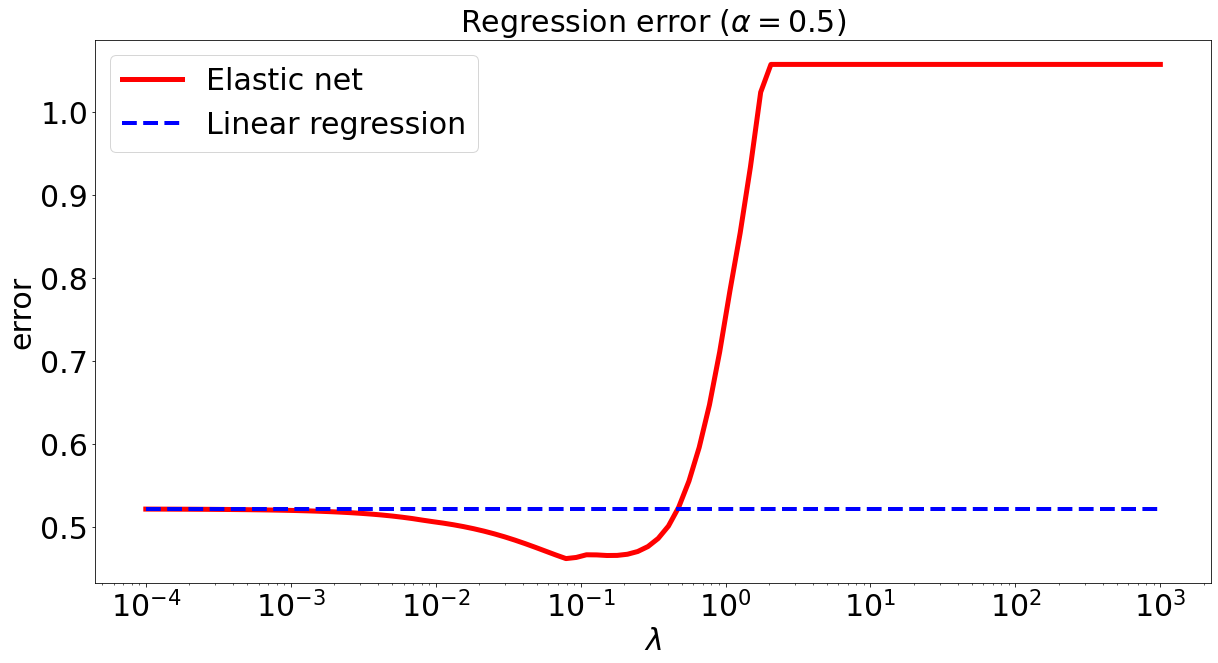

In [111]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

In [112]:
min(err_eln)

0.461469717533694

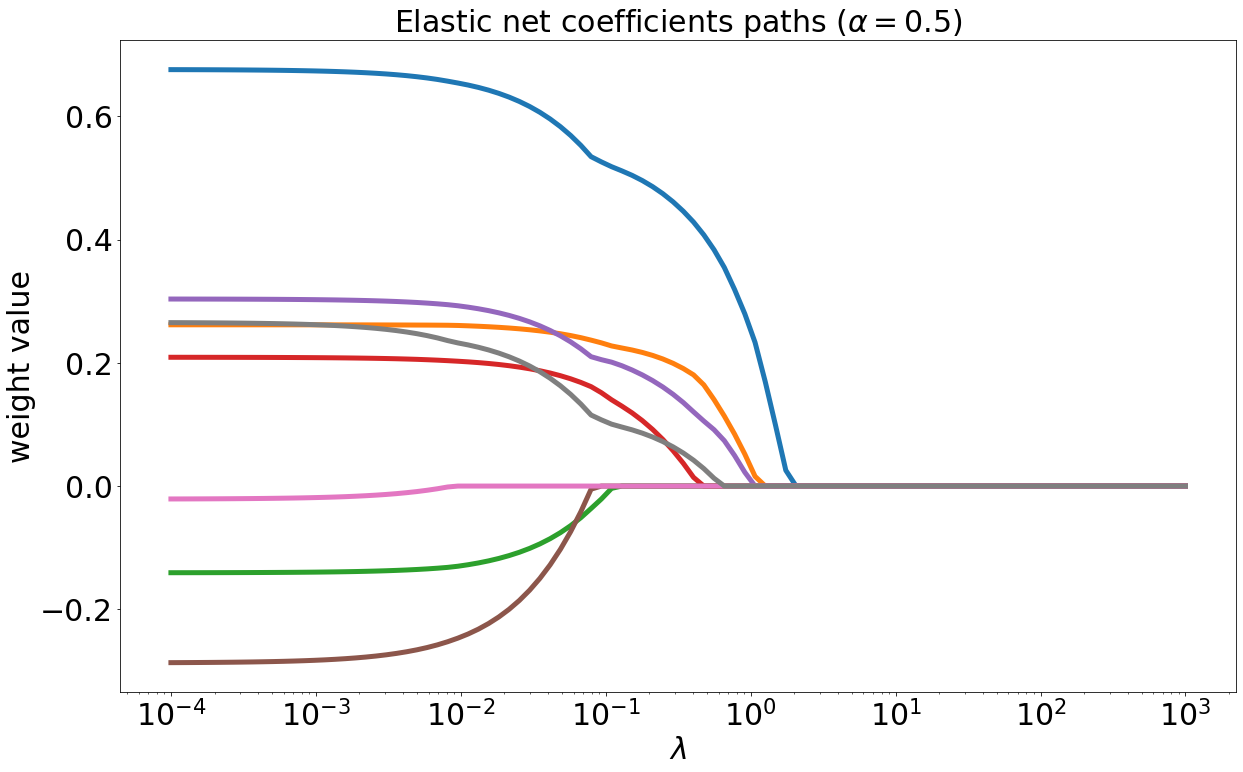

In [113]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

#as expected the Elastic net keeps more variables than the Lasso

# Model selection

In [114]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

#Lasso is more parsimonious but there is likely to be a loss of accuracy.
#Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso.

Linear regression error:   0.5213
Minimun ridge error:       0.4859
Minimum lasso error:       0.4525
Minimum elastic net error: 0.4615
